In [19]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.cm as cm
from pathlib import Path
import norm
import physconst as pc
from vtk_reader import read_vtk

In [20]:
data_dir = Path('/Users/satoukakeru/lab/Jet_Torus/runs')
run_ids = ['00a2']
fname = 'accretion_rate.dat'

In [21]:
data_fbase = 'data'
data_type = 'flt'
nc = 128
ndata = [302]
grid = [nc, nc, nc]
nvar = 7
x1_min, x1_max = -5., 5.  # code units
x2_min, x2_max = -5., 5.  # code units
x3_min, x3_max = -5., 5.  # code units
dx1 = (x1_max - x1_min) / grid[0]
dx2 = (x2_max - x2_min) / grid[1]
dx3 = (x3_max - x3_min) / grid[2]
cell_volume = dx1 * dx2 * dx3

do_dens_cut = False

nm = norm.PhysNorm(x=pc.pc, v=pc.c, dens=0.60364*pc.amu, temp=pc.c*pc.c*pc.amu/pc.kboltz, curr=1.)
fnum2year = nm.t / pc.yr * 24.5009005929988

In [33]:
x1 = np.linspace(x1_min, x1_max, nc)
x2 = np.linspace(x2_min, x2_max, nc)
x3 = np.linspace(x3_min, x3_max, nc)
x1g, x2g, x3g = np.meshgrid(x1, x2, x2, sparse=True)
r2_1 = (x1g - 3.5) * (x1g - 3.5) + x2g * x2g + x3g * x3g
r2_2 = x1g * x1g + x2g * x2g + (x3g - 3.5) * (x3g - 3.5)
r2_3 = (x1g + 3.5) * (x1g + 3.5) + x2g * x2g + x3g * x3g
r2_4 = x1g * x1g + x2g * x2g + (x3g + 3.5) * (x3g + 3.5)

In [34]:
mass_1 = []
mass_2 = []
mass_3 = []
mass_4 = []
for ir, run_id in enumerate(run_ids):
    for idata in range(ndata[ir]):
        data_fname = data_dir / run_id / f'{data_fbase}.{idata:0>4d}.{data_type}'

        if data_type == 'flt':
            hydro = np.fromfile(data_fname, dtype=np.float32).reshape((nvar, grid[2], grid[1], grid[0]))
            density = hydro[0, :, :, :]
            density_cut_1 = np.ma.masked_where(r2_1>0.50*0.50, density)
            density_cut_2 = np.ma.masked_where(r2_2>0.50*0.50, density)
            density_cut_3 = np.ma.masked_where(r2_3>0.50*0.50, density)
            density_cut_4 = np.ma.masked_where(r2_4>0.50*0.50, density)
            if do_dens_cut:
                density_cut_1 = np.ma.masked_less(density_cut_1, 0.1)
                density_cut_2 = np.ma.masked_less(density_cut_2, 0.1)
                density_cut_3 = np.ma.masked_less(density_cut_3, 0.1)
                density_cut_4 = np.ma.masked_less(density_cut_4, 0.1)

        elif data_type == 'vtk':
            with open(data_fname, 'rb') as fp:
                hydro = read_vtk(fp, grid[0], grid[1], grid[2])

        mass_1.append(np.sum(density_cut_1) * cell_volume * nm.m / pc.msun)
        mass_2.append(np.sum(density_cut_2) * cell_volume * nm.m / pc.msun)
        mass_3.append(np.sum(density_cut_3) * cell_volume * nm.m / pc.msun)
        mass_4.append(np.sum(density_cut_4) * cell_volume * nm.m / pc.msun)

    time = np.arange(idata+1) * fnum2year
    time_diff = np.diff(time)

    mass_diff_1 = -np.diff(mass_1)
    mdot_1 = mass_diff_1 / time_diff

    mass_diff_2 = -np.diff(mass_2)
    mdot_2 = mass_diff_2 / time_diff

    mass_diff_3 = -np.diff(mass_3)
    mdot_3 = mass_diff_3 / time_diff

    mass_diff_4 = -np.diff(mass_4)
    mdot_4 = mass_diff_4 / time_diff

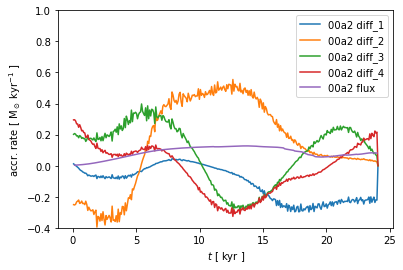

In [37]:
pl.plot(time[1:] / 1000., mdot_1 * 1000, label=f'{run_id} diff_1')
pl.plot(time[1:] / 1000., mdot_2 * 1000, label=f'{run_id} diff_2')
pl.plot(time[1:] / 1000., mdot_3 * 1000, label=f'{run_id} diff_3')
pl.plot(time[1:] / 1000., mdot_4 * 1000, label=f'{run_id} diff_4')

for run_id in run_ids:
    acc_time, acc_rate, acc_power, mbh, edd_power = np.loadtxt(data_dir / run_id / fname, unpack=True)
    u_time, ui = np.unique(acc_time, return_index=True)
    pl.plot(u_time / 1000., acc_rate[ui] * 1000, label=f'{run_id} flux')

pl.xlabel(r'$t$ [ kyr ]')
pl.ylabel(r'accr. rate [ M$_\odot$ kyr$^{-1}$ ]')
pl.ylim(-0.4, 1.0)
pl.legend()

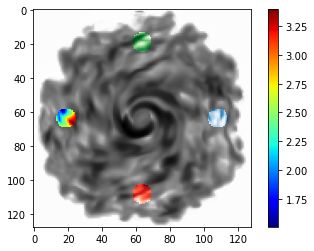

In [42]:
pl.imshow(np.log10(density[64, :, :]), cmap=cm.Greys)
pl.imshow(np.log10(density_cut_1[64, :, :]), cmap=cm.Reds)
pl.imshow(np.log10(density_cut_2[64, :, :]), cmap=cm.Blues)
pl.imshow(np.log10(density_cut_3[64, :, :]), cmap=cm.Greens)
pl.imshow(np.log10(density_cut_4[64, :, :]), cmap=cm.jet)
pl.colorbar()

/Users/satoukakeru/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/satoukakeru/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/satoukakeru/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/satoukakeru/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/satoukakeru/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, fl

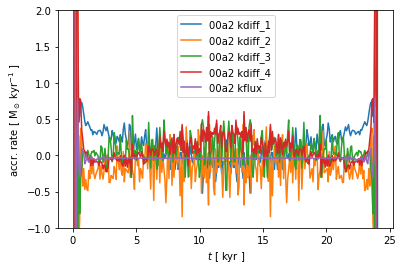

In [46]:
kspace_diff_1 = np.fft.fft(mdot_1 * 1000)
pl.plot(time[1:] / 1000., kspace_diff_1, label=f'{run_id} kdiff_1')

kspace_diff_2 = np.fft.fft(mdot_2 * 1000)
pl.plot(time[1:] / 1000., kspace_diff_2, label=f'{run_id} kdiff_2')

kspace_diff_3 = np.fft.fft(mdot_3 * 1000)
pl.plot(time[1:] / 1000., kspace_diff_3, label=f'{run_id} kdiff_3')

kspace_diff_4 = np.fft.fft(mdot_4 * 1000)
pl.plot(time[1:] / 1000., kspace_diff_4, label=f'{run_id} kdiff_4')

kspace_flux = np.fft.fft(acc_rate[ui] * 1000)

for run_id in run_ids:
    acc_time, acc_rate, acc_power, mbh, edd_power = np.loadtxt(data_dir / run_id / fname, unpack=True)
    u_time, ui = np.unique(acc_time, return_index=True)
    pl.plot(u_time / 1000., kspace_flux, label=f'{run_id} kflux')

pl.xlabel(r'$t$ [ kyr ]')
pl.ylabel(r'accr. rate [ M$_\odot$ kyr$^{-1}$ ]')
pl.ylim(-1.0, 2.0)
pl.legend()